In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import random
import re
import string

import nltk

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

In [4]:
df = pd.read_csv('10_accounts.csv',index_col=[0])

In [5]:
df['text']

0         I Read Cathie Wood’s Ark Invest’s 132 Page “Bi...
1         Crypto Platforms Should Offer Investors Same P...
2                                         I would guess 80%
3         Crypto Support Is Growing on Capitol Hill\n\nS...
4         Algorand Brings a Level of Maturity to the Blo...
                                ...                        
130239                                 This tweet is a test
130240    Most households to reach grid parity with sola...
130241    GMail Tip:  just discovered you can drag label...
130242     It was thru your mention in This week in star...
130243    Giving TweetDeck a go... in my camper...  Out ...
Name: text, Length: 126363, dtype: object

In [6]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neelj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neelj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()
    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\w+…|…", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    tokens = tokenizer(text)
    tokens = [t for t in tokens if not t in stopwords]
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    return tokens

In [8]:
df['tokens'] = df['text'].map(lambda x: clean_text(x, word_tokenize, stopwords.words("english")))

In [9]:
tokenized_lists = df['tokens'].tolist()

In [10]:
model = Word2Vec(sentences=tokenized_lists, vector_size=100, workers=1, seed=SEED)

In [11]:
def vectorize(tokenized_lists, model):
    features = []
    for tokens in tokenized_lists:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [12]:
vectorized_lists = vectorize(tokenized_lists, model)
len(vectorized_lists), len(vectorized_lists[0])

(126363, 100)

In [13]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [14]:
cluster_sse_dict = {}
cluster_dist_dict = {}
for k in range(1,20):
    km = MiniBatchKMeans(n_clusters=k, batch_size=500).fit(vectorized_lists)
    cluster_sse_dict[k] = km.inertia_
    cluster_dist_dict[k] = sum(np.min(cdist(vectorized_lists, km.cluster_centers_, 'euclidean'), axis=1)) / len(vectorized_lists)

C:\Users\neelj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1047: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "
C:\Users\neelj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1047: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "
C:\Users\neelj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1047: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by

In [15]:
print('Inertia (SSE)')
for k, v in cluster_sse_dict.items():
    print(f'{k} : {v}')

Inertia (SSE)
1 : 1492463.7612381536
2 : 1303588.155396306
3 : 1153916.701214585
4 : 1064641.670454681
5 : 1008894.1124024424
6 : 993940.755895469
7 : 955432.7147817126
8 : 922715.342360619
9 : 896925.4014940932
10 : 893058.8537439583
11 : 883383.6348167191
12 : 870969.7915442054
13 : 855824.1420040992
14 : 849229.1189935378
15 : 837658.517643155
16 : 834439.4837345949
17 : 815660.5900438068
18 : 826965.0544222161
19 : 800832.1217798833


In [16]:
print('Distortion')
for k, v in cluster_dist_dict.items():
    print(f'{k} : {v}')

Distortion
1 : 3.2208878389811004
2 : 3.0034572118914356
3 : 2.8074813588231815
4 : 2.7144178484997457
5 : 2.6396668652950734
6 : 2.614553786570718
7 : 2.5631636955243944
8 : 2.5239181905233066
9 : 2.4840592259637266
10 : 2.477666444588855
11 : 2.4681202812838685
12 : 2.448605475254797
13 : 2.4283996805215113
14 : 2.4147416578721446
15 : 2.404954516302075
16 : 2.3980668901190847
17 : 2.3679224545358024
18 : 2.3905651701092765
19 : 2.3468350707423826


Text(0.5, 0, '# of Clusters')

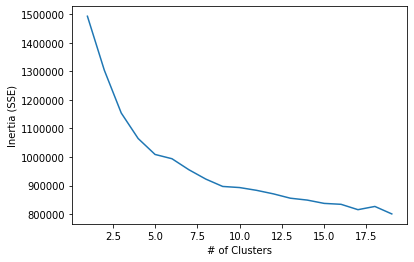

In [17]:
plt.plot(list(cluster_sse_dict.keys()),list(cluster_sse_dict.values()))
plt.ylabel('Inertia (SSE)')
plt.xlabel('# of Clusters')

Text(0.5, 0, '# of Clusters')

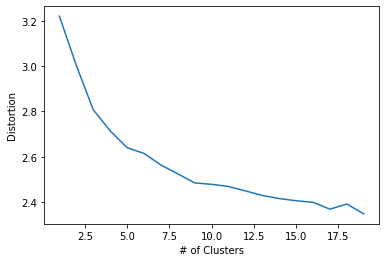

In [18]:
plt.plot(list(cluster_dist_dict.keys()),list(cluster_dist_dict.values()))
plt.ylabel('Distortion')
plt.xlabel('# of Clusters')

In [19]:
def mbkmeans_clusters(X, k, mb, print_silhouette_values):
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [20]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_lists, k=9, mb=500, print_silhouette_values=True)
df_clusters = pd.DataFrame({"text": df['text'], "tokens": [" ".join(text) for text in tokenized_lists], "cluster": cluster_labels})

C:\Users\neelj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1047: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 9
Silhouette coefficient: 0.09
Inertia:898972.7580857432
Silhouette values:
    Cluster 8: Size:3607 | Avg:0.31 | Min:-0.05 | Max: 0.50
    Cluster 2: Size:6311 | Avg:0.25 | Min:0.01 | Max: 0.42
    Cluster 4: Size:20388 | Avg:0.15 | Min:-0.05 | Max: 0.33
    Cluster 0: Size:21149 | Avg:0.11 | Min:0.01 | Max: 0.27
    Cluster 5: Size:13830 | Avg:0.06 | Min:-0.05 | Max: 0.23
    Cluster 3: Size:15211 | Avg:0.05 | Min:-0.13 | Max: 0.23
    Cluster 7: Size:23055 | Avg:0.05 | Min:-0.08 | Max: 0.22
    Cluster 6: Size:10771 | Avg:0.04 | Min:-0.14 | Max: 0.21
    Cluster 1: Size:12041 | Avg:0.01 | Min:-0.18 | Max: 0.24


In [21]:
df_clusters

,text,tokens,cluster
0,I Read Cathie Wood’s Ark Invest’s 132 Page “Bi...,read cathie wood ark invest page big ideas rep...,4
1,Crypto Platforms Should Offer Investors Same P...,crypto platforms offer investors protections s...,4
2,I would guess 80%,would guess,7
3,Crypto Support Is Growing on Capitol Hill\n\nS...,crypto support growing capitol hill sentiment ...,4
4,Algorand Brings a Level of Maturity to the Blo...,algorand brings level maturity blockchain spac...,4
...,...,...,...
130239,This tweet is a test,tweet test,1
130240,Most households to reach grid parity with sola...,households reach grid parity solar power,0
130241,GMail Tip: just discovered you can drag label...,gmail tip discovered drag labels left directly...,0
130242,It was thru your mention in This week in star...,thru mention week startups thought check busin...,1


In [22]:
print("Most representative terms per cluster (based on centroids):")
for i in range(9):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: dexes bricks responsibly emphasizing gamblers 
Cluster 1: regularly subscribing newsletters hopium rsc 
Cluster 2: dipping 38k orange revisited convincingly 
Cluster 3: peaks fluctuated declines hourly flat 
Cluster 4: readreuters visas jpmorgans targeting nyse 
Cluster 5: blockspace unwind capped proportional incomes 
Cluster 6: preceded bottomed ranging corrective check👇 
Cluster 7: knowing sometimes rarely sleep proper 
Cluster 8: pleasure thank cheers shoutout ✌️ 
